# 3. Modelo: Clasificador BERT

Se busca predecir la rama del arbol de categorias en la que se encuentra un producto dado.

### Enlaces

- [Text Classification with BERT in PyTorch](https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f)
- [Best models](https://huggingface.co/models)

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import sys
sys.path.append('../../src')

from matplotlib import pyplot as plt
import seaborn as sns

import numpy  as np
import pandas as pd
import torch
from   torch import nn

import logging

import data  as dt
import model as ml
import util  as ut
import pytorch_common.util as pu

import transformers

## Setup

Se configura el default logger para que la consola sea el output y loguee mensajes a partir del nivel INFO.

In [7]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

Por defecto usamos GPU. De no existir este hardware, el fallback es CPU:

In [8]:
torch.cuda.is_available()

True

In [9]:
torch.__version__

'1.12.1+cu116'

In [10]:
pu.set_device_name('gpu')

logging.info(pu.get_device())

2022-09-25 20:32:51,910 - INFO - cuda:0


In [11]:
torch.cuda.get_arch_list()

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']

Fijamos la semilla:

In [12]:
ut.set_seed(42)

Modelo pre entrenado a utilizar. Este es una capa/module mas de nuestro modelo:

In [13]:
BERT_MODEL ='bert-base-uncased'
# BERT_MODEL ='distilbert-base-uncased'
# BERT_MODEL ='albert-base-v2'

Parametros de la notebook:

In [14]:
DATASET_PATH       = '../../datasets/ebay'
WEIGHTS_PATH       = '../../weights'
CACHE_PATH         = '../../cache'
MODEL_WEIGHTS_PATH = f'{WEIGHTS_PATH}/ebay_{BERT_MODEL}_weights.h5'

!mkdir -p {WEIGHTS_PATH}

## Cargar dataset

In [15]:
train_set = pd.read_csv(f'{DATASET_PATH}/train.csv')
val_set   = pd.read_csv(f'{DATASET_PATH}/val.csv')
test_set  = pd.read_csv(f'{DATASET_PATH}/test.csv')

In [16]:
train_set.head()

,title,category,tokens_count,category_seq
0,Filtron AR234/5 Air Filter,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,4,32
1,Vegans Deserve Better than a Fruit Salad by Da...,"eBay ~ Books, Comics & Magazines ~ Books",12,15
2,OSRAM 334 / 294 24v 21/5w Single Bulb Stop Sid...,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,14,33
3,Borg & Beck BBW1589 Wheel Cylinder,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,6,64
4,Delphi FG1070-12B1 Fuel Feed Unit,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,5,87


Tamaño máximo de la secuencia de entrada:

In [17]:
tokens_count = 2 + train_set['tokens_count'].max()
tokens_count

40

In [18]:
tokenizer = ml.Tokenizer(
    tokenizer  = transformers.BertTokenizer.from_pretrained(BERT_MODEL), 
    padding    = 'max_length',
    max_length = tokens_count
)

In [19]:
train_dataset = dt.Dataset(train_set, feature_col = 'title', target_col = 'category_seq', tokenizer = tokenizer)
val_dataset   = dt.Dataset(val_set,   feature_col = 'title', target_col = 'category_seq', tokenizer = tokenizer)
test_dataset  = dt.Dataset(test_set,  feature_col = 'title', target_col = 'category_seq', tokenizer = tokenizer)

Cantidad de clases a predecir:

In [20]:
n_classes = train_set['category_seq'].unique().shape[0]
n_classes

122

In [26]:
classifier = ml.Classifier(
    transformer     = transformers.BertModel.from_pretrained(
        BERT_MODEL, 
        use_cache = True, 
        cache_dir = CACHE_PATH
    ),
    output_dim      = n_classes,
    dropout         = 0.2,
    hiden_state_dim = 768
)

## Entrenamiento y evaluación

In [27]:
model = ml.ModelTrainer(classifier, batch_size = 25, criterion  = nn.CrossEntropyLoss())

In [ ]:
LR     = 0.0001
EPOCHS = 10

model.fit(
    train_dataset, 
    val_dataset = val_dataset,
    optimizer   = torch.optim.Adam(classifier.parameters(), lr = LR),
    epochs      = EPOCHS
)

In [32]:
classifier.save(MODEL_WEIGHTS_PATH)

In [39]:
classifier.load(MODEL_WEIGHTS_PATH)

In [40]:
summary = model.validate(test_dataset)
summary.accuracy, summary.loss

(0.8762886597938144, 0.02945801400646721)

In [41]:
np.concatenate(summary.predictions).shape

(97,)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           4       1.00      1.00      1.00         2
           6       0.00      0.00      0.00         0
           9       1.00      0.50      0.67         2
          10       0.50      1.00      0.67         1
          11       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         1
          15       1.00      0.91      0.95        11
          16       1.00      1.00      1.00         1
          17       0.67      1.00      0.80         2
          18       1.00      1.00      1.00         1
          19       0.50      0.50      0.50         2
          20       1.00      1.00      1.00         2
          21       1.00      1.00      1.00         1
          22       0.00      0.00      0.00         1
          23       1.00      1.00      1.00         1
          24       1.00      1.00      1.00         1
          25       0.50    

<Figure size 2500x2500 with 2 Axes>

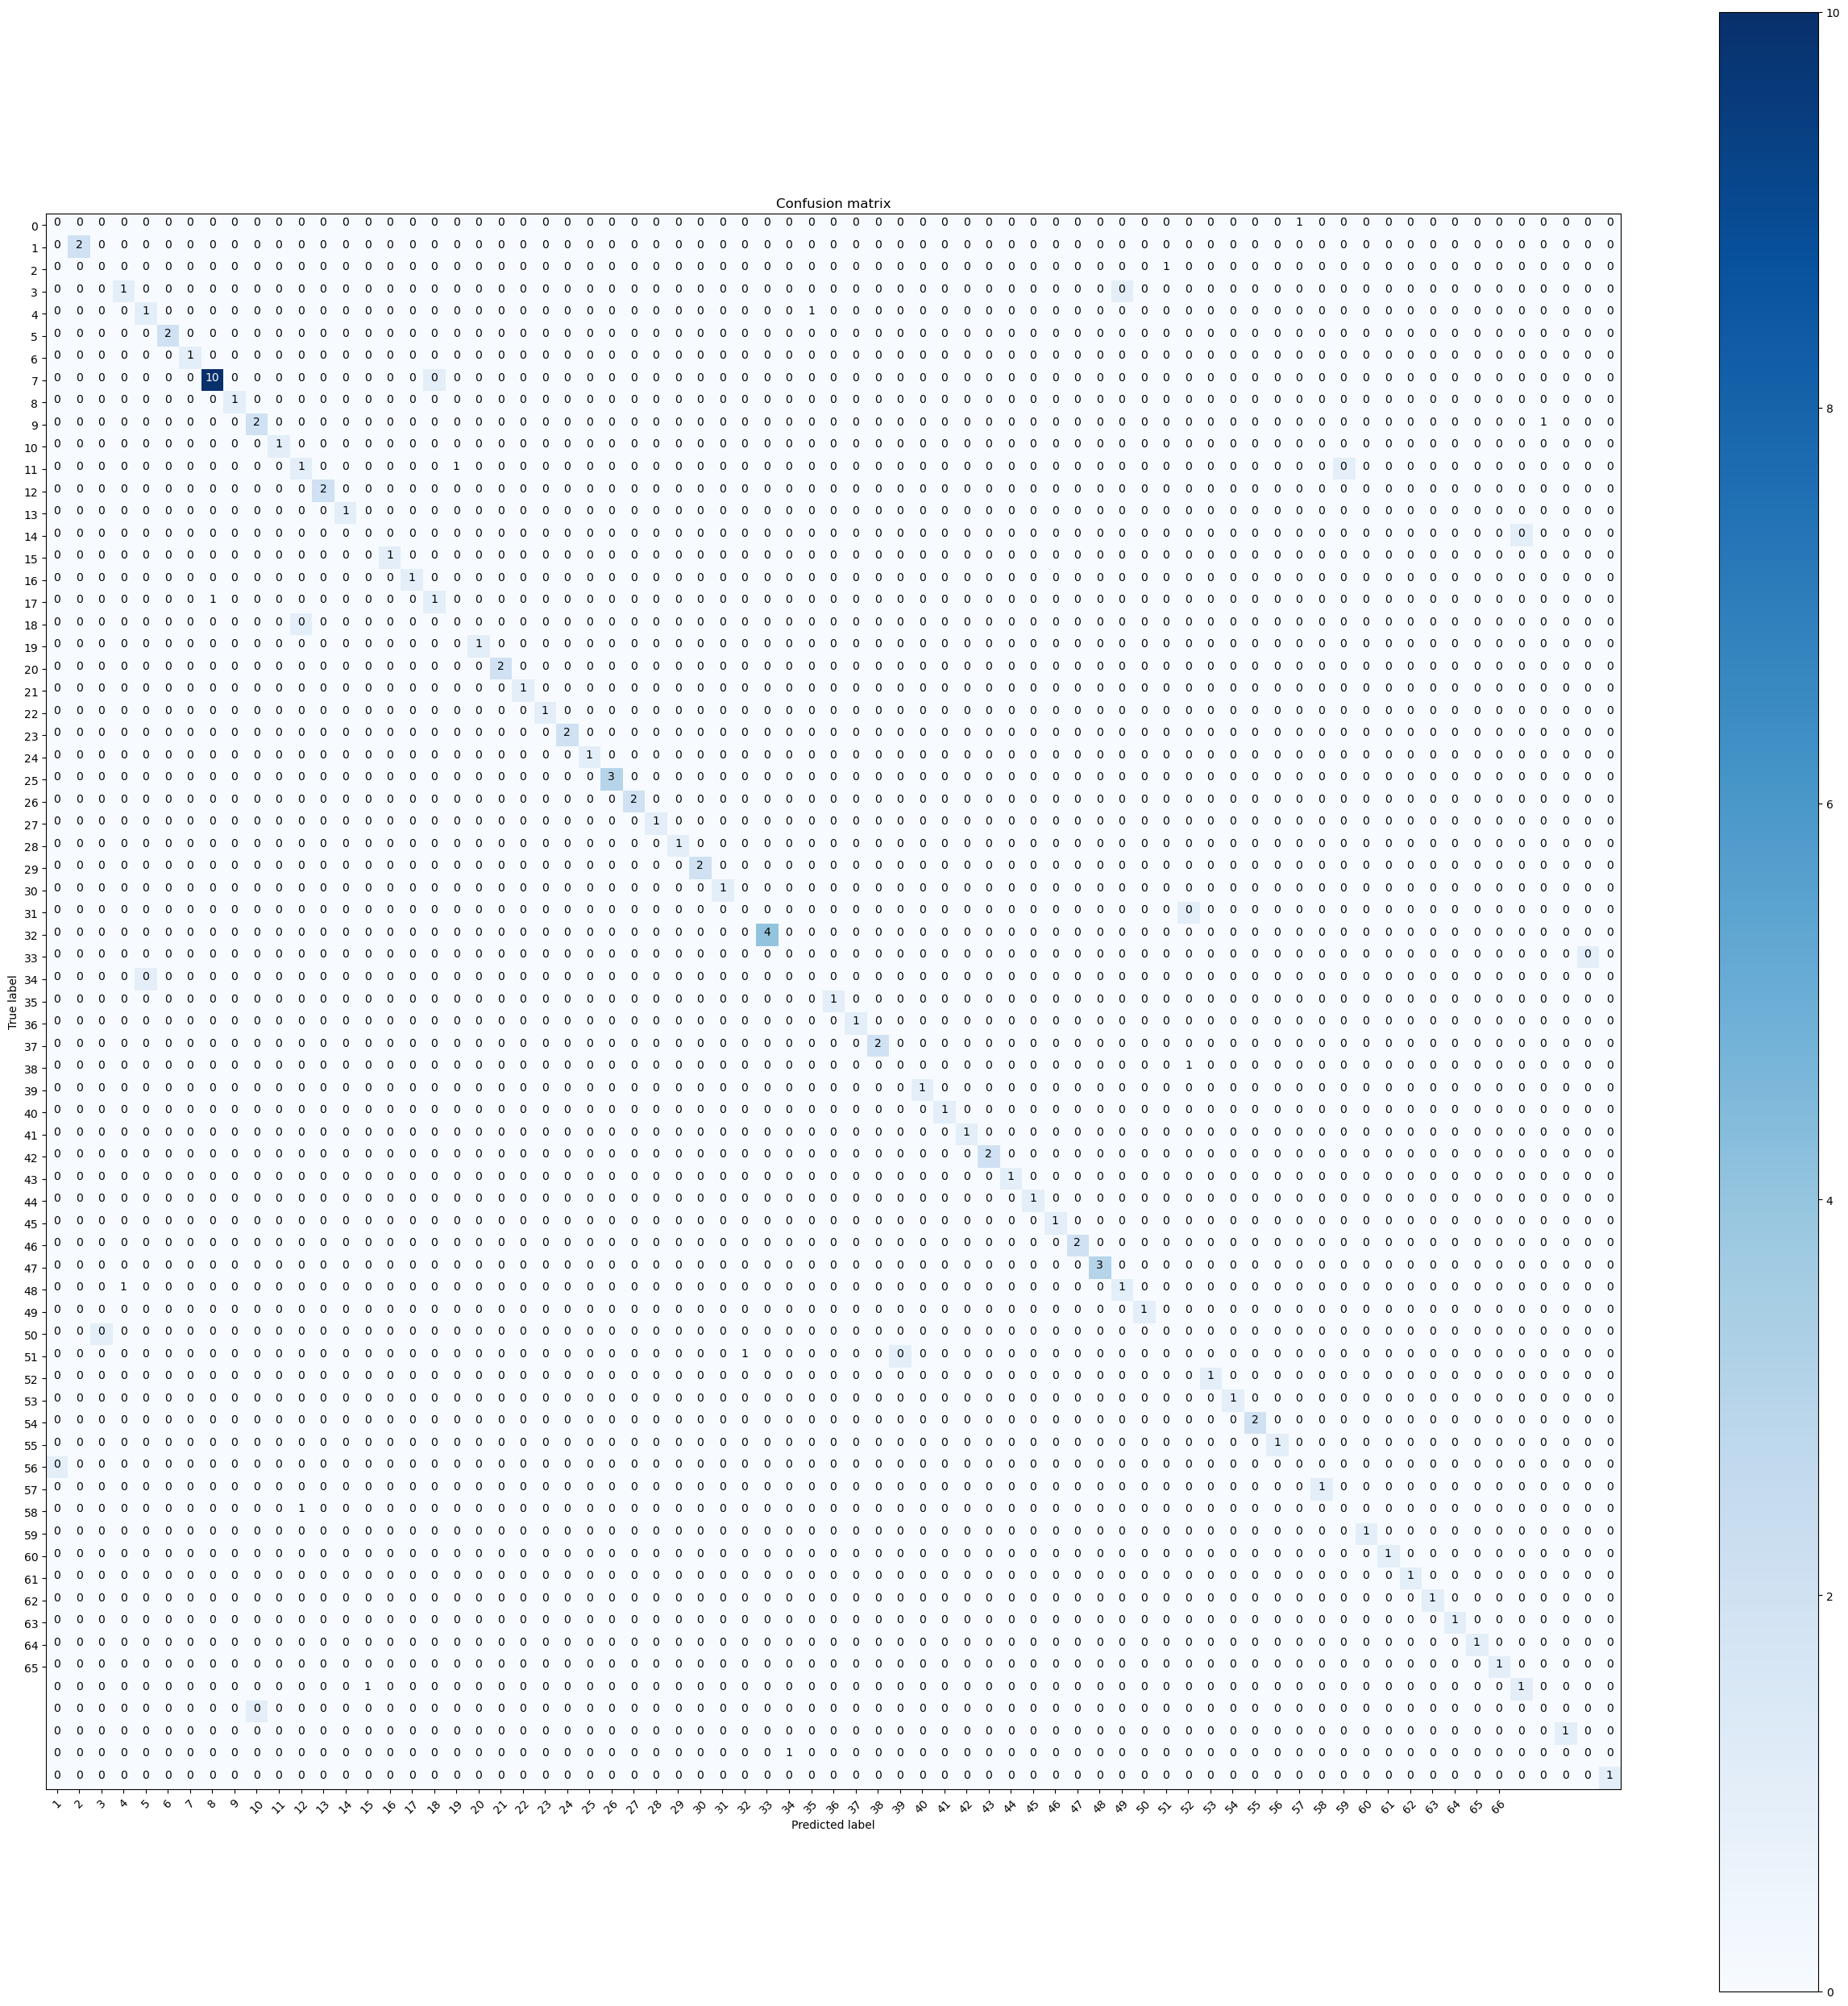

In [45]:
summary.plot_metrics()